# Retrieving Gender Information in Nouns & Adjectives using Minimum Intra-class STD + Maximum extra-class average diff
In this Notebook : attempts to isolate Word Embeddings dimension coding for **gender information** (masculine/feminine) in a sample of Word Embeddings for **NOUNS**, **ADJECTIVES** and **both**.  

## 0. Data Loading

In [1]:
import pandas as pd

# WE loading
all_n_we = pd.read_csv('../Data/FlauBERT_WE/all_nouns_we.csv', index_col=0).drop(columns=["number"])
all_a_we = pd.read_csv('../Data/FlauBERT_WE/all_adjectives_we.csv', index_col=0).drop(columns = ["number"])
all_na_we = pd.concat([all_n_we, all_a_we])

# Normalization: values fall within -1 and 1
for i in range(512):
    for df in [all_n_we, all_a_we, all_na_we]:
        values, copy = list(df[str(i)]), list(df[str(i)])
        copy.sort()
        min_, max_ = copy[0], copy[len(copy)-1]
        df[str(i)] = [val / (max_ - min_) for val in values]


## 1. Lowest intra-class standard deviation

Separate the data into two classes: masculine and feminine.

In [2]:
masc_n_we = all_n_we[all_n_we["gender"] == "masculine"]
fem_n_we = all_n_we[all_n_we["gender"] == "feminine"]

masc_a_we = all_a_we[all_a_we["gender"] == "masculine"]
fem_a_we = all_a_we[all_a_we["gender"] == "feminine"]

masc_na_we = pd.concat([masc_n_we, masc_a_we])
fem_na_we = pd.concat([fem_n_we, fem_a_we])

Lowest std for class **masculine**:

In [3]:
lm1 = list(masc_n_we.loc[:,:'511'].std().sort_values()[:10].index)
masc_n_we.loc[:,:'511'].std().sort_values()[:10]

287    0.101875
441    0.102557
209    0.103562
365    0.104139
12     0.104285
314    0.105332
69     0.105587
338    0.106061
321    0.106727
25     0.107155
dtype: float64

In [4]:
lm2 = list(masc_a_we.loc[:,:'511'].std().sort_values()[:10].index)
masc_a_we.loc[:,:'511'].std().sort_values()[:10]

441    0.102064
421    0.106235
293    0.106943
133    0.107553
314    0.108192
55     0.108246
321    0.110656
218    0.110790
312    0.110992
432    0.111151
dtype: float64

In [5]:
lm3 = list(masc_na_we.loc[:,:'511'].std().sort_values()[:10].index)
masc_na_we.loc[:,:'511'].std().sort_values()[:10]

441    0.102720
314    0.107128
293    0.107356
321    0.108268
209    0.109155
421    0.110520
432    0.110620
338    0.111097
507    0.111340
422    0.111938
dtype: float64

Lowest std for class **feminine**:

In [6]:
lf1 = list(fem_n_we.loc[:,:'511'].std().sort_values()[:10].index)
fem_n_we.loc[:,:'511'].std().sort_values()[:10]

83     0.100318
287    0.101198
365    0.101676
314    0.101889
209    0.102343
408    0.102378
25     0.102705
69     0.103277
441    0.105249
422    0.105414
dtype: float64

In [7]:
lf2 = list(fem_a_we.loc[:,:'511'].std().sort_values()[:10].index)
fem_a_we.loc[:,:'511'].std().sort_values()[:10]

421    0.103869
441    0.104395
314    0.107642
321    0.107700
357    0.108180
55     0.109419
293    0.109445
312    0.109605
328    0.109956
478    0.110642
dtype: float64

In [8]:
lf3 = list(fem_na_we.loc[:,:'511'].std().sort_values()[:10].index)
fem_na_we.loc[:,:'511'].std().sort_values()[:10]

441    0.105856
314    0.106132
321    0.107296
209    0.107403
422    0.108377
25     0.108584
365    0.108813
421    0.109097
408    0.109709
69     0.109839
dtype: float64

Check if these dimensions separate classes masculine and feminine:

For NOUNS:

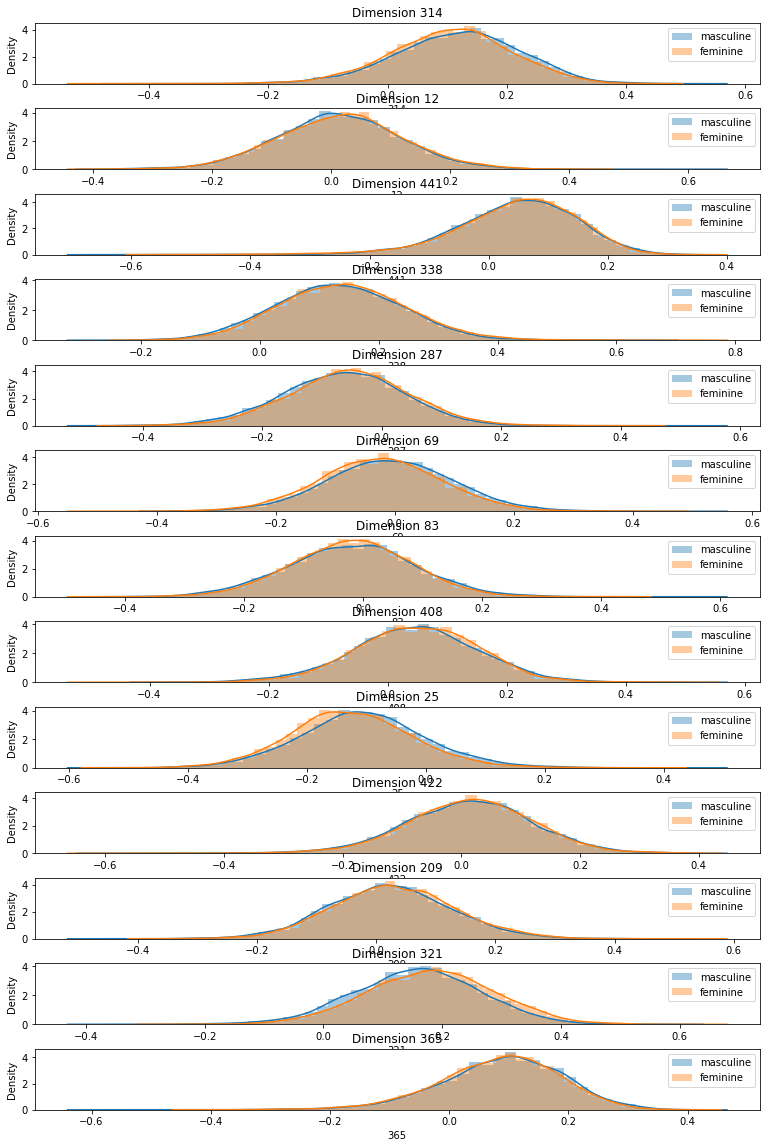

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

n = len(list(set(lm1 + lf1)))
fig, axs = plt.subplots(n, 1, figsize=(n, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, dim in enumerate(list(set(lm1 + lf1))):
    sns.distplot(masc_n_we[dim], ax=axs[i], label="masculine")
    sns.distplot(fem_n_we[dim], ax=axs[i], label="feminine")
    axs[i].legend()
    axs[i].set_title("Dimension " + dim)
plt.show()

ADJ:

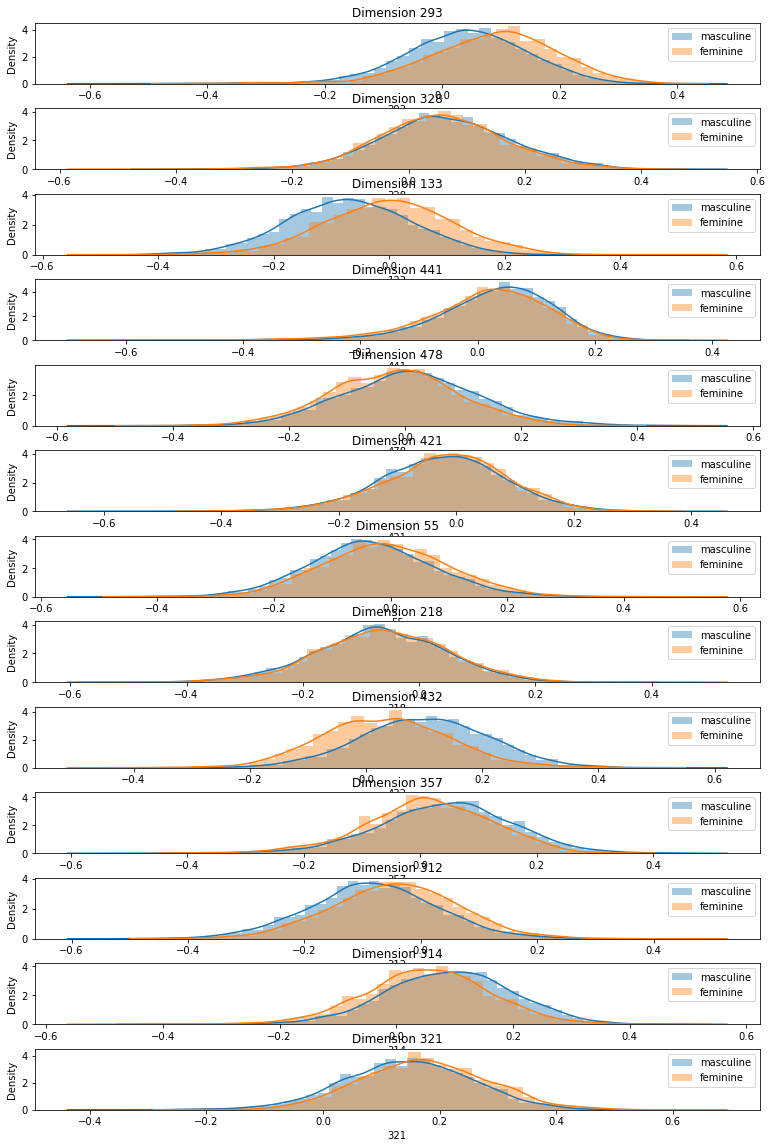

In [10]:
n = len(list(set(lm2 + lf2)))
fig, axs = plt.subplots(n, 1, figsize=(n, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, dim in enumerate(list(set(lm2 + lf2))):
    sns.distplot(masc_a_we[dim], ax=axs[i], label="masculine")
    sns.distplot(fem_a_we[dim], ax=axs[i], label="feminine")
    axs[i].legend()
    axs[i].set_title("Dimension " + dim)
plt.show()

NOUN + ADJ:

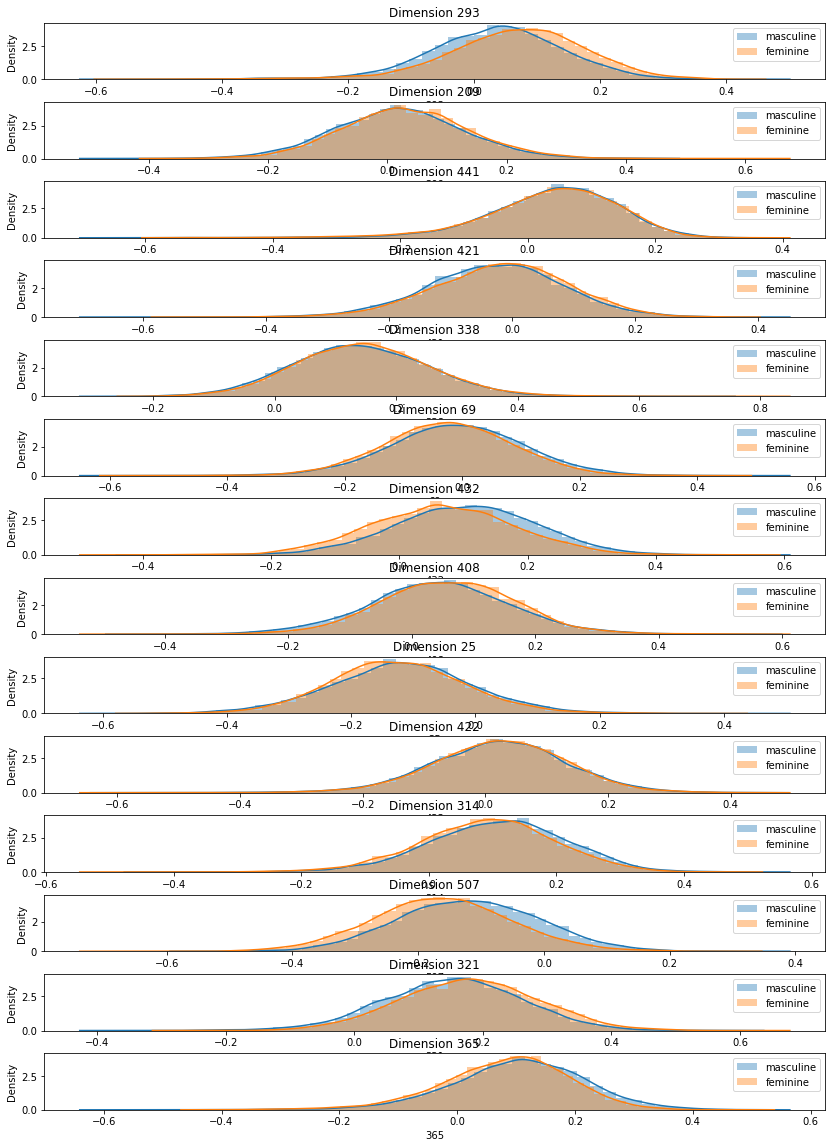

In [11]:
n = len(list(set(lm3 + lf3)))
fig, axs = plt.subplots(n, 1, figsize=(n, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, dim in enumerate(list(set(lm3 + lf3))):
    sns.distplot(masc_na_we[dim], ax=axs[i], label="masculine")
    sns.distplot(fem_na_we[dim], ax=axs[i], label="feminine")
    axs[i].legend()
    axs[i].set_title("Dimension " + dim)
plt.show()

We see that these dimensions do not only have low intra-class std, but also extra-class std, as te distributions clearly overlap between masculine and feminine. We reject the hypothesis that they encode gender.

## 2. Dimensions with greatest difference between avg_masc and avg_fem

In [12]:
masc_n_avg = masc_n_we.loc[:,:'511'].mean()
fem_n_avg = fem_n_we.loc[:,:'511'].mean()
d_n_avg = abs(masc_n_avg - fem_n_avg)

masc_a_avg = masc_a_we.loc[:,:'511'].mean()
fem_a_avg = fem_a_we.loc[:,:'511'].mean()
d_a_avg = abs(masc_a_avg - fem_a_avg)

masc_na_avg = masc_na_we.loc[:,:'511'].mean()
fem_na_avg = fem_na_we.loc[:,:'511'].mean()
d_na_avg = abs(masc_na_avg - fem_na_avg)

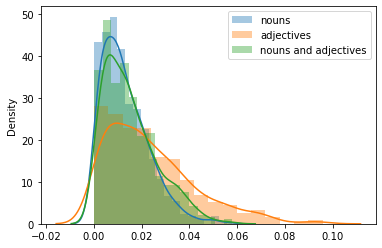

In [13]:
# plot the distribution of differences
sns.distplot(d_n_avg, label="nouns")
sns.distplot(d_a_avg, label="adjectives")
sns.distplot(d_na_avg, label="nouns and adjectives")
plt.legend()
plt.show()

This seems encouraging, as few dimensions present the highest differences for each of the considered datasets. We also see higher differences in adjectives.

In [14]:
# top 10 dimensions with the highest difference
d_n_avg.sort_values(ascending=False)[:10]

100    0.055799
316    0.049773
245    0.049634
195    0.049573
192    0.044940
202    0.043488
117    0.041494
121    0.040833
507    0.040379
499    0.037995
dtype: float64

In [15]:
d_a_avg.sort_values(ascending=False)[:10]

466    0.095789
250    0.093239
439    0.091811
503    0.086161
245    0.077255
181    0.075772
5      0.074988
192    0.072612
234    0.072420
88     0.071186
dtype: float64

In [16]:
d_na_avg.sort_values(ascending=False)[:10]

245    0.057962
192    0.054360
250    0.050286
121    0.049977
5      0.047551
276    0.045291
439    0.045152
181    0.044543
507    0.044016
195    0.043406
dtype: float64